# Preprocess data into Vector DataBase

First step is to process data into vectordb, so that we can create a retirever to load the data.

### Load the data
There are many loaders being supported in langchain. I choose PDF loader here.

In [1]:
from langchain.document_loaders import PyMuPDFLoader
path="data/道路交通安全規則.pdf"
loader = PyMuPDFLoader(path)
pdf_data = loader.load()

# Use the RecursiveCharacterTextSplitter to split the text into chunks
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=5)
all_splits = text_splitter.split_documents(pdf_data)

### Embedding Model

There are many embedding models, I choose two embedding models to conduct the experiment:
- `text-embedding-3-small`: Charged
- `all-MiniLM-L6-v2`: Free

In [2]:
embedding_name = "all-MiniLM-L6-v2"

if embedding_name == "text-embedding-3-small":
    from key import API_KEY
    from langchain.embeddings import OpenAIEmbeddings
    import os
    os.environ["OPENAI_API_KEY"] = API_KEY
    embedding = OpenAIEmbeddings(model="text-embedding-3-small")
elif embedding_name == "all-MiniLM-L6-v2":
    from langchain.embeddings import HuggingFaceEmbeddings
    model_name = "sentence-transformers/all-MiniLM-L6-v2"
    model_kwargs = {'device': 'cpu'}
    embedding = HuggingFaceEmbeddings(model_name=model_name,
                                    model_kwargs=model_kwargs)
else:
    raise NotImplementedError

/tmp/ipykernel_3148087/3204744953.py:13: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  embedding = HuggingFaceEmbeddings(model_name=model_name,
/home/torridfish/RAG-experiment/env/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/home/torridfish/RAG-experiment/env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depr

### Create the vector database

In [3]:
from langchain.vectorstores import Chroma
persist_directory = 'db'
vectordb = Chroma.from_documents(documents=all_splits, embedding=embedding, persist_directory=persist_directory)

## Language Model
Here we use the api service provided by `llamafactory-cli` to hold our LLM.

Use the following command to setup the service:
```
API_PORT=8000 llamafactory-cli api model_info.yaml
```

After we've create the host, we can use `ChatOpenAI` to get the output.

To combine llm with langchain, the office suggests us to use [LCEL (LangChain Expression Language)](https://python.langchain.com/v0.1/docs/expression_language/) to formualate the chain.

In [22]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

llm = ChatOpenAI(
    openai_api_key='None', 
    openai_api_base='http://0.0.0.0:8000/v1',
    temperature=0.5,    
)

messages = [
    (
        "system",
        "You are a helpful assistant that translates English to Traditional Chinese. Translate the user sentence.",
    ),
    ("human", "Nice to meet you! What a wonderful day!"),
]

# LECL example
chain = (
    llm # The OpenAI model
    | StrOutputParser() # Parse the output of the OpenAI model
)

print(chain.invoke(messages))

Traditional Chinese translation:

好久不見！今天真好！


## Normal LLM versus RAG

First, is the chain of normal LLM.

We only apply template and output parser before and after the inference of llm.

In [4]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

llm = ChatOpenAI(
    openai_api_key='None', 
    openai_api_base='http://0.0.0.0:8000/v1',
    temperature=0
)

template = """Answer the following questions. If you don't know the answer, please say "I don't know".
---
Question {question}
"""

template = ChatPromptTemplate.from_template(template)

def log_prompt(prompt):
    # Print the prompt in green
    print("\033[92m{}\033[00m".format(prompt.to_string().replace("human: ", "")))  
    return prompt

normal_chain = (
    {"question": RunnablePassthrough()}
    | template
    | RunnableLambda(log_prompt)
    | llm
    | StrOutputParser()
)

Second, is the implementation of RAG.

Apart from what we've done, we also create a retriever when we get the user's input. 

Then we provide the infomation into the prompt, so that models can response better.

In [24]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

retriever = vectordb.as_retriever()

llm = ChatOpenAI(
    openai_api_key='None', 
    openai_api_base='http://0.0.0.0:8000/v1',
    temperature=0
)

template = """Answer the following questions with the extra infomation below. If you don't know the answer, please say "I don't know".

Extra information:
```
{context}
```

---
Question {question}
"""

template = ChatPromptTemplate.from_template(template)

def log_prompt(prompt):
    # Print the prompt in green
    print("\033[92m{}\033[00m".format(prompt.to_string().replace("human: ", "")))  
    return prompt

def doc_format(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"question": RunnablePassthrough(), "context": retriever | doc_format} 
    | template
    | RunnableLambda(log_prompt)
    | llm
    | StrOutputParser()
)

Let's take a look of the result:

In [25]:
question = "請問大貨車載運劇團道具附載演員不得超過幾人呢？"
print(normal_chain.invoke(question))

Human: Answer the following questions. If you don't know the answer, please say "I don't know".
---
Question 請問大貨車載運劇團道具附載演員不得超過幾人呢？

I don't know


In [26]:
question = "請問大貨車載運劇團道具附載演員不得超過幾人呢？"
print(rag_chain.invoke(question))

Human: Answer the following questions with the extra infomation below. If you don't know the answer, please say "I don't know".

Extra information:
```
三、漁民攜帶大型捕魚工具，非客車所能容納者，搭載大貨車不得超過十六人，小貨車不得超過
八人。
四、大貨車載運劇團道具附載演員不得超過十六人，小貨車不得超過八人。

三、漁民攜帶大型捕魚工具，非客車所能容納者，搭載大貨車不得超過十六人，小貨車不得超過
八人。
四、大貨車載運劇團道具附載演員不得超過十六人，小貨車不得超過八人。

五、大貨車載運魚苗附載拍水人員不得超過十二人。
六、大貨車載運棺柩附載人員不得超過十六人。
七、大貨車載運神轎附載人員不得超過十六人。

五、大貨車載運魚苗附載拍水人員不得超過十二人。
六、大貨車載運棺柩附載人員不得超過十六人。
七、大貨車載運神轎附載人員不得超過十六人。
```

---
Question 請問大貨車載運劇團道具附載演員不得超過幾人呢？

根據提供的資訊，大貨車載運劇團道具附載演員不得超過十六人。


## Test on traffic law in Taiwan

In [5]:
import json
from tqdm import tqdm
with open("data/test.jsonl", "r") as f:
    data = [json.loads(line) for line in f]     

Collect the output from nromal chain:

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

llm = ChatOpenAI(
    openai_api_key='None', 
    openai_api_base='http://0.0.0.0:8000/v1',
    temperature=0
)

template = """Answer the following questions. If you don't know the answer, please say "I don't know".
---
Question {question}
"""

template = ChatPromptTemplate.from_template(template)

finetuned_chain = (
    {"question": RunnablePassthrough()}
    | template
    | llm
    | StrOutputParser()
)

finetuned_chain_results = []
for item in tqdm(data):
    result = finetuned_chain.invoke(item["question"])
    finetuned_chain_results.append(result)

100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


In [7]:
with open("output/finetuned_chain_ckpt_400_results.jsonl", "w") as f:
    for result, data in zip(finetuned_chain_results, data):
        f.write(json.dumps({"question": data["question"], "output": result}, ensure_ascii=False) + "\n")

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

retriever = vectordb.as_retriever()

llm = ChatOpenAI(
    openai_api_key='None', 
    openai_api_base='http://0.0.0.0:8000/v1',
    temperature=0
)

template = """Answer the following questions with the extra infomation below. If you don't know the answer, please say "I don't know".

Extra information:
```
{context}
```

---
Question {question}
"""

template = ChatPromptTemplate.from_template(template)

def doc_format(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"question": RunnablePassthrough(), "context": retriever | doc_format} 
    | template
    | llm
    | StrOutputParser()
)

rag_chain_embedding_huggingface_results = []
for item in tqdm(data):
    result = rag_chain.invoke(item["question"])
    rag_chain_embedding_huggingface_results.append(result)

100%|██████████| 100/100 [02:42<00:00,  1.62s/it]


In [7]:
with open("output/rag_chain_embedding_huggingface_results.jsonl", "w") as f:
    for result, data in zip(rag_chain_embedding_huggingface_results, data):
        f.write(json.dumps({"question": data["question"], "output": result}, ensure_ascii=False) + "\n")

Total Accuracy: 50.00%


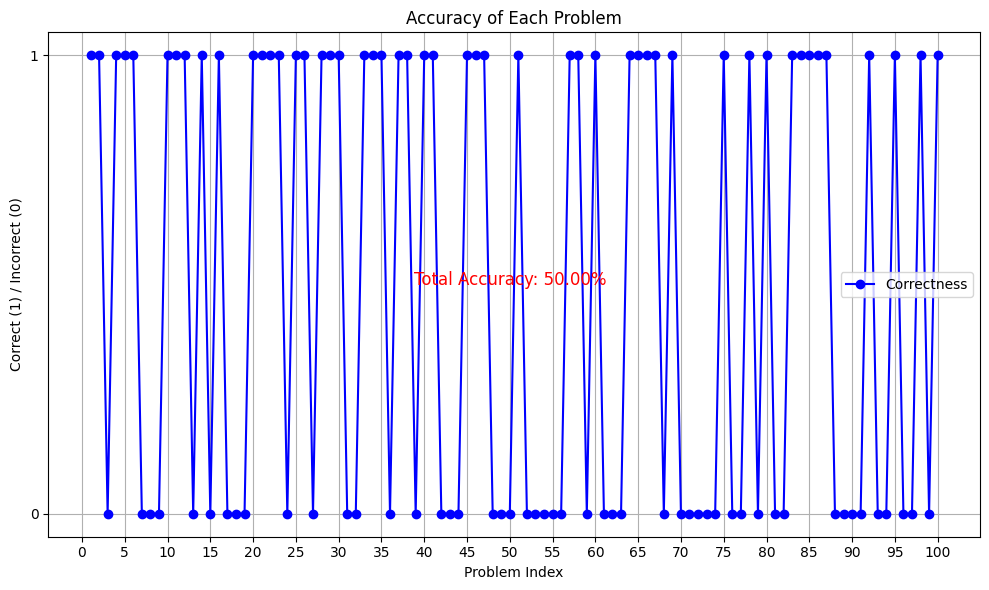

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the jsonl data into a pandas DataFrame
data = [
    {"idx": 1, "correct": 1}, {"idx": 2, "correct": 1}, {"idx": 3, "correct": 0},
    {"idx": 4, "correct": 1}, {"idx": 5, "correct": 1}, {"idx": 6, "correct": 1},
    {"idx": 7, "correct": 0}, {"idx": 8, "correct": 0}, {"idx": 9, "correct": 0},
    {"idx": 10, "correct": 1}, {"idx": 11, "correct": 1}, {"idx": 12, "correct": 1},
    {"idx": 13, "correct": 0}, {"idx": 14, "correct": 1}, {"idx": 15, "correct": 0},
    {"idx": 16, "correct": 1}, {"idx": 17, "correct": 0}, {"idx": 18, "correct": 0},
    {"idx": 19, "correct": 0}, {"idx": 20, "correct": 1}, {"idx": 21, "correct": 1},
    {"idx": 22, "correct": 1}, {"idx": 23, "correct": 1}, {"idx": 24, "correct": 0},
    {"idx": 25, "correct": 1}, {"idx": 26, "correct": 1}, {"idx": 27, "correct": 0},
    {"idx": 28, "correct": 1}, {"idx": 29, "correct": 1}, {"idx": 30, "correct": 1},
    {"idx": 31, "correct": 0}, {"idx": 32, "correct": 0}, {"idx": 33, "correct": 1},
    {"idx": 34, "correct": 1}, {"idx": 35, "correct": 1}, {"idx": 36, "correct": 0},
    {"idx": 37, "correct": 1}, {"idx": 38, "correct": 1}, {"idx": 39, "correct": 0},
    {"idx": 40, "correct": 1}, {"idx": 41, "correct": 1}, {"idx": 42, "correct": 0},
    {"idx": 43, "correct": 0}, {"idx": 44, "correct": 0}, {"idx": 45, "correct": 1},
    {"idx": 46, "correct": 1}, {"idx": 47, "correct": 1}, {"idx": 48, "correct": 0},
    {"idx": 49, "correct": 0}, {"idx": 50, "correct": 0}, {"idx": 51, "correct": 1},
    {"idx": 52, "correct": 0}, {"idx": 53, "correct": 0}, {"idx": 54, "correct": 0},
    {"idx": 55, "correct": 0}, {"idx": 56, "correct": 0}, {"idx": 57, "correct": 1},
    {"idx": 58, "correct": 1}, {"idx": 59, "correct": 0}, {"idx": 60, "correct": 1},
    {"idx": 61, "correct": 0}, {"idx": 62, "correct": 0}, {"idx": 63, "correct": 0},
    {"idx": 64, "correct": 1}, {"idx": 65, "correct": 1}, {"idx": 66, "correct": 1},
    {"idx": 67, "correct": 1}, {"idx": 68, "correct": 0}, {"idx": 69, "correct": 1},
    {"idx": 70, "correct": 0}, {"idx": 71, "correct": 0}, {"idx": 72, "correct": 0},
    {"idx": 73, "correct": 0}, {"idx": 74, "correct": 0}, {"idx": 75, "correct": 1},
    {"idx": 76, "correct": 0}, {"idx": 77, "correct": 0}, {"idx": 78, "correct": 1},
    {"idx": 79, "correct": 0}, {"idx": 80, "correct": 1}, {"idx": 81, "correct": 0},
    {"idx": 82, "correct": 0}, {"idx": 83, "correct": 1}, {"idx": 84, "correct": 1},
    {"idx": 85, "correct": 1}, {"idx": 86, "correct": 1}, {"idx": 87, "correct": 1},
    {"idx": 88, "correct": 0}, {"idx": 89, "correct": 0}, {"idx": 90, "correct": 0},
    {"idx": 91, "correct": 0}, {"idx": 92, "correct": 1}, {"idx": 93, "correct": 0},
    {"idx": 94, "correct": 0}, {"idx": 95, "correct": 1}, {"idx": 96, "correct": 0},
    {"idx": 97, "correct": 0}, {"idx": 98, "correct": 1}, {"idx": 99, "correct": 0},
    {"idx": 100, "correct": 1}
]

df = pd.DataFrame(data)

# Calculate the total accuracy
total_accuracy = df['correct'].mean() * 100
print(f"Total Accuracy: {total_accuracy:.2f}%")

# Plot the accuracy of each problem
plt.figure(figsize=(10, 6))
plt.plot(df['idx'], df['correct'], marker='o', linestyle='-', color='b', label='Correctness')
plt.xlabel('Problem Index')
plt.ylabel('Correct (1) / Incorrect (0)')
plt.title('Accuracy of Each Problem')
plt.xticks(range(0, 101, 5))
plt.yticks([0, 1])
plt.grid(True)

# Display total accuracy in the plot
plt.text(50, 0.5, f'Total Accuracy: {total_accuracy:.2f}%', fontsize=12, color='red', ha='center')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
